In [47]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [48]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [49]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [50]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [51]:
tf.keras.backend.clear_session()

In [52]:
subject = 'Amapá - Consumo de Cimento (t)'
start_index = 0
split_index = 191 #Referente aos 230 anos de input 
window_size = 36
train_split = split_index + 1 -30

In [53]:
data = pd.read_csv('2003_mo_model_input_AP.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Amapá - IDH Longevidade,Amapá- custo m2 (R$),Amapá - IDH,Amapá - Consumo de Cimento (t),Amapá - IDH Renda,Amapá - PIB - Estadual,Amapá - PIB - Construção Civil,Amapá - PIB - Per Capita,Amapá - PIB - Preços de Mercado,Amapá - IDH Educacao,Amapá - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Amapá - Depósito Poupança (R$)
0,2003-1,0.774101,10518.903600,0.711421,10.392,0.689809,8.035813e+06,356591.003430,10.883143,7.033593e+06,0.676675,8.514392,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,205197.602881
1,2003-2,0.774476,10623.124754,0.711553,6.857,0.689704,8.046432e+06,356647.711004,10.885206,7.037356e+06,0.676859,8.508753,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,205498.444071
2,2003-3,0.774851,10723.388458,0.711685,7.011,0.689598,8.057052e+06,356704.418579,10.887268,7.041120e+06,0.677044,8.503114,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,205799.285261
3,2003-4,0.775226,10817.834529,0.711817,7.122,0.689493,8.067671e+06,356761.126153,10.889331,7.044883e+06,0.677228,8.497475,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,206100.126450
4,2003-5,0.775601,10909.780391,0.711949,5.267,0.689387,8.078290e+06,356817.833728,10.891394,7.048646e+06,0.677413,8.491835,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,206400.967640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,37300.779456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,NaN,37265.020607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,NaN,37205.249516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,NaN,37124.790031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


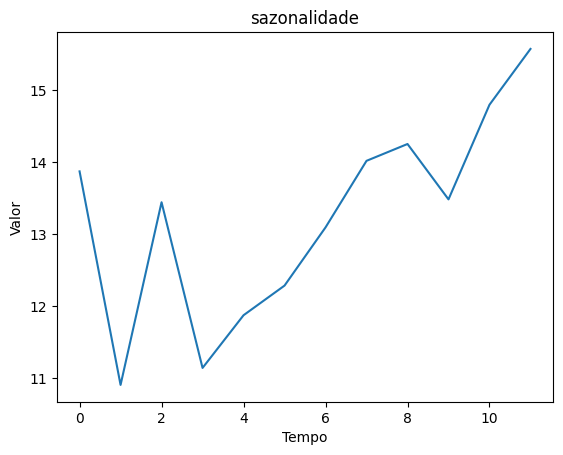

,sazonalidade
sazonalidade,
0,13.872317
1,10.906147
2,13.443547
3,11.142231
4,11.874151
5,12.285879
6,13.094215
7,14.018887
8,14.252757


In [54]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [55]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Amapá - IDH Longevidade,Amapá- custo m2 (R$),Amapá - IDH,Amapá - IDH Renda,Amapá - PIB - Estadual,Amapá - PIB - Construção Civil,Amapá - PIB - Per Capita,Amapá - PIB - Preços de Mercado,Amapá - IDH Educacao,Amapá - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Amapá - Depósito Poupança (R$),sazonalidade,Amapá - Consumo de Cimento (t)
0,2003-1,0.774101,10518.903600,0.711421,0.689809,8.035813e+06,356591.003430,10.883143,7.033593e+06,0.676675,8.514392,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,205197.602881,13.872317,10.392
1,2003-2,0.774476,10623.124754,0.711553,0.689704,8.046432e+06,356647.711004,10.885206,7.037356e+06,0.676859,8.508753,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,205498.444071,10.906147,6.857
2,2003-3,0.774851,10723.388458,0.711685,0.689598,8.057052e+06,356704.418579,10.887268,7.041120e+06,0.677044,8.503114,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,205799.285261,13.443547,7.011
3,2003-4,0.775226,10817.834529,0.711817,0.689493,8.067671e+06,356761.126153,10.889331,7.044883e+06,0.677228,8.497475,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,206100.126450,11.142231,7.122
4,2003-5,0.775601,10909.780391,0.711949,0.689387,8.078290e+06,356817.833728,10.891394,7.048646e+06,0.677413,8.491835,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,206400.967640,11.874151,5.267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,37300.779456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.874151,NaN
245,2023-6,NaN,37265.020607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.285879,NaN
246,2023-7,NaN,37205.249516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.094215,NaN
247,2023-8,NaN,37124.790031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.018887,NaN


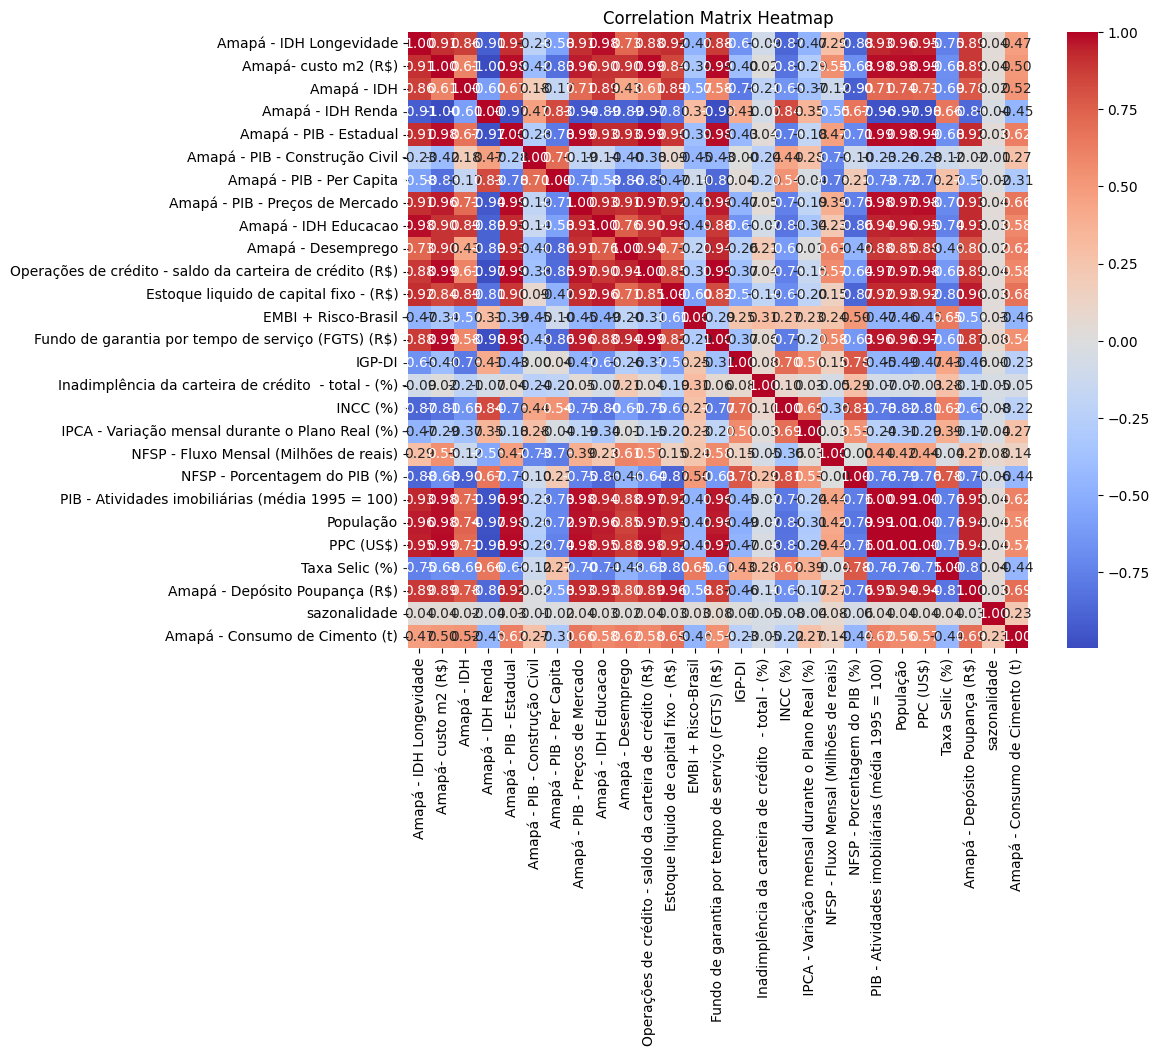

In [56]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [57]:
# data =data.drop(['Air Temperature - Dry Bulb (°C)',
#                  'Precipitation (mm/day)',
#                  'Global Radiation - Daylight (Kj/m²)', 
#                  'Air Relative Humidity (%)'], axis=1)
# data

In [58]:
input_data = data.iloc[:split_index + 1,1:-1]
# mean = np.mean(input_data, axis=0)
# stddev =  np.std(input_data, axis=0)
# input_data = ((input_data - mean) /stddev)
scaler=MinMaxScaler()
scaled_data = scaler.fit_transform(input_data)
input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Amapá - IDH Longevidade,Amapá- custo m2 (R$),Amapá - IDH,Amapá - IDH Renda,Amapá - PIB - Estadual,Amapá - PIB - Construção Civil,Amapá - PIB - Per Capita,Amapá - PIB - Preços de Mercado,Amapá - IDH Educacao,Amapá - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Amapá - Depósito Poupança (R$),sazonalidade
0,0.000000,0.000000,0.000000,1.000000,0.000000,0.377078,0.459772,0.000000,0.000000,0.031250,0.000000,0.000000,0.108706,0.015290,1.000000,0.790380,1.000000,1.000000,0.310283,1.000000,0.000000,0.000000,0.000000,0.813935,0.000000,0.635530
1,0.012749,0.006316,0.016604,0.995651,0.006441,0.379481,0.472574,0.010515,0.010707,0.030561,0.000205,0.011007,0.058377,0.004961,0.936603,0.788742,0.968938,0.921240,0.311059,0.965719,0.001556,0.007992,0.003548,0.698054,0.000765,0.000000
2,0.025499,0.012392,0.033208,0.991303,0.012882,0.381885,0.485377,0.021030,0.021414,0.029871,0.000218,0.022015,0.100305,0.000973,0.906543,0.788333,0.948438,0.873107,0.303979,0.927412,0.003112,0.015984,0.007210,1.000000,0.001529,0.543662
3,0.038248,0.018115,0.049812,0.986954,0.019322,0.384288,0.498179,0.031545,0.032121,0.029182,0.000375,0.033022,0.211591,0.000000,0.858675,0.787696,0.928794,0.851659,0.287789,0.885588,0.004668,0.023976,0.010957,0.629650,0.002294,0.050583
4,0.050998,0.023687,0.066416,0.982605,0.025763,0.386691,0.510981,0.042060,0.042828,0.028493,0.000871,0.044030,0.358835,0.002281,0.824839,0.784532,0.970421,0.823277,0.294233,0.838034,0.006586,0.031968,0.014605,0.795263,0.003058,0.207404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,0.868629,0.966329,0.524987,0.020114,0.968856,0.047639,0.017632,0.956972,0.726986,0.901730,0.974735,0.828698,0.187214,0.826290,0.381401,0.228511,0.005731,0.000000,0.794606,0.030808,0.978656,0.987600,0.987346,0.075260,0.797858,0.666934
188,0.862673,0.974344,0.502010,0.015086,0.965298,0.050101,0.013224,0.952114,0.704959,0.898637,0.979913,0.823090,0.197767,0.819012,0.466609,0.204051,0.037761,0.029504,0.869001,0.027720,0.985034,0.990700,0.990952,0.052572,0.801212,0.717043
189,0.856717,0.982724,0.479033,0.010057,0.961740,0.052562,0.008816,0.947256,0.682932,0.895544,0.987793,0.817482,0.203626,0.880142,0.530936,0.163703,0.087044,0.043125,0.879026,0.023074,0.991411,0.993800,0.994312,0.013826,0.804566,0.552219
190,0.850762,0.991434,0.456057,0.005029,0.958182,0.055024,0.004408,0.942399,0.660906,0.892451,0.994612,0.811875,0.204541,0.957076,0.611274,0.131737,0.118264,0.059756,0.928863,0.017547,0.995706,0.996900,0.997384,0.056080,0.807919,0.833906


In [59]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-12)
target_data

0      10.000
1       6.136
2       5.122
3       3.926
4       6.197
        ...  
244       NaN
245       NaN
246       NaN
247       NaN
248       NaN
Name: Amapá - Consumo de Cimento (t), Length: 249, dtype: float64

In [60]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Amapá - IDH Longevidade,Amapá- custo m2 (R$),Amapá - IDH,Amapá - IDH Renda,Amapá - PIB - Estadual,Amapá - PIB - Construção Civil,Amapá - PIB - Per Capita,Amapá - PIB - Preços de Mercado,Amapá - IDH Educacao,Amapá - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Amapá - Depósito Poupança (R$),sazonalidade
0,0.000000,0.000000,0.000000,1.000000,0.000000,0.377078,0.459772,0.000000,0.000000,0.031250,0.000000,0.000000,0.108706,0.015290,1.000000,0.790380,1.000000,1.000000,0.310283,1.000000,0.000000,0.000000,0.000000,0.813935,0.000000,0.635530
1,0.012749,0.006316,0.016604,0.995651,0.006441,0.379481,0.472574,0.010515,0.010707,0.030561,0.000205,0.011007,0.058377,0.004961,0.936603,0.788742,0.968938,0.921240,0.311059,0.965719,0.001556,0.007992,0.003548,0.698054,0.000765,0.000000
2,0.025499,0.012392,0.033208,0.991303,0.012882,0.381885,0.485377,0.021030,0.021414,0.029871,0.000218,0.022015,0.100305,0.000973,0.906543,0.788333,0.948438,0.873107,0.303979,0.927412,0.003112,0.015984,0.007210,1.000000,0.001529,0.543662
3,0.038248,0.018115,0.049812,0.986954,0.019322,0.384288,0.498179,0.031545,0.032121,0.029182,0.000375,0.033022,0.211591,0.000000,0.858675,0.787696,0.928794,0.851659,0.287789,0.885588,0.004668,0.023976,0.010957,0.629650,0.002294,0.050583
4,0.050998,0.023687,0.066416,0.982605,0.025763,0.386691,0.510981,0.042060,0.042828,0.028493,0.000871,0.044030,0.358835,0.002281,0.824839,0.784532,0.970421,0.823277,0.294233,0.838034,0.006586,0.031968,0.014605,0.795263,0.003058,0.207404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,0.997042,0.805621,0.987023,0.175992,0.980118,0.093565,0.049927,0.968794,0.993373,0.996442,0.981805,0.956993,0.467381,0.857984,0.039971,0.643262,0.182507,0.379453,0.469629,0.024030,0.843175,0.890665,0.874793,0.365935,0.713445,0.000000
158,0.994083,0.810047,0.974046,0.169737,0.981925,0.085059,0.051900,0.971631,0.986746,0.992884,0.978077,0.953662,0.483414,0.846039,0.027548,0.709146,0.168812,0.332832,0.458182,0.021531,0.843824,0.893949,0.878731,0.401765,0.712749,0.543662
159,0.991125,0.814366,0.961069,0.163482,0.983733,0.076553,0.053873,0.974468,0.980119,0.989327,0.974383,0.950331,0.485402,0.830400,0.037038,0.729647,0.152959,0.313954,0.439618,0.019385,0.844473,0.897232,0.882759,0.379504,0.712053,0.050583
160,0.988167,0.818643,0.948092,0.157228,0.985540,0.068047,0.055846,0.977305,0.973492,0.985769,0.971205,0.947000,0.480289,0.827217,0.070841,0.729821,0.137613,0.294856,0.456732,0.017671,0.844268,0.900516,0.886861,0.440821,0.711357,0.207404


In [61]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      10.000
1       6.136
2       5.122
3       3.926
4       6.197
        ...  
157     8.322
158    11.373
159     9.651
160    10.855
161    13.970
Name: Amapá - Consumo de Cimento (t), Length: 162, dtype: float64

In [62]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [63]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(126, 36, 26)

In [64]:
# input para treinamento
test_input = input_data.iloc[train_split-window_size:split_index + 1]
test_input

,Amapá - IDH Longevidade,Amapá- custo m2 (R$),Amapá - IDH,Amapá - IDH Renda,Amapá - PIB - Estadual,Amapá - PIB - Construção Civil,Amapá - PIB - Per Capita,Amapá - PIB - Preços de Mercado,Amapá - IDH Educacao,Amapá - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Amapá - Depósito Poupança (R$),sazonalidade
126,0.723526,0.625059,0.816354,0.403792,0.856454,0.776195,0.439882,0.929165,0.793894,0.854574,0.758748,0.994213,0.038989,0.611173,0.201912,0.381658,0.372054,0.612440,0.198892,0.052718,0.831584,0.780557,0.769083,0.131587,0.879848,0.468814
127,0.722253,0.631708,0.802872,0.404440,0.861855,0.767179,0.418917,0.929945,0.784755,0.861253,0.766876,0.995177,0.054581,0.615820,0.209545,0.325565,0.375438,0.626227,0.212790,0.056653,0.834382,0.784414,0.772016,0.217266,0.859823,0.666934
128,0.720980,0.638390,0.789390,0.405089,0.867255,0.758162,0.397953,0.930726,0.775615,0.867931,0.775150,0.996142,0.070743,0.616446,0.238038,0.273745,0.372254,0.645442,0.219584,0.060771,0.837180,0.788271,0.774681,0.241706,0.839798,0.717043
129,0.719706,0.645092,0.775907,0.405738,0.872655,0.749146,0.376989,0.931506,0.766476,0.874609,0.786449,0.997106,0.084331,0.663874,0.249843,0.198953,0.369458,0.673151,0.215246,0.065105,0.839978,0.792128,0.777064,0.080099,0.819773,0.552219
130,0.718433,0.651738,0.762425,0.406386,0.878056,0.740129,0.356024,0.932287,0.757337,0.881288,0.798019,0.998071,0.095511,0.722141,0.266770,0.131822,0.371547,0.699949,0.236663,0.069099,0.840204,0.795984,0.779225,0.033180,0.799747,0.833906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,0.868629,0.966329,0.524987,0.020114,0.968856,0.047639,0.017632,0.956972,0.726986,0.901730,0.974735,0.828698,0.187214,0.826290,0.381401,0.228511,0.005731,0.000000,0.794606,0.030808,0.978656,0.987600,0.987346,0.075260,0.797858,0.666934
188,0.862673,0.974344,0.502010,0.015086,0.965298,0.050101,0.013224,0.952114,0.704959,0.898637,0.979913,0.823090,0.197767,0.819012,0.466609,0.204051,0.037761,0.029504,0.869001,0.027720,0.985034,0.990700,0.990952,0.052572,0.801212,0.717043
189,0.856717,0.982724,0.479033,0.010057,0.961740,0.052562,0.008816,0.947256,0.682932,0.895544,0.987793,0.817482,0.203626,0.880142,0.530936,0.163703,0.087044,0.043125,0.879026,0.023074,0.991411,0.993800,0.994312,0.013826,0.804566,0.552219
190,0.850762,0.991434,0.456057,0.005029,0.958182,0.055024,0.004408,0.942399,0.660906,0.892451,0.994612,0.811875,0.204541,0.957076,0.611274,0.131737,0.118264,0.059756,0.928863,0.017547,0.995706,0.996900,0.997384,0.056080,0.807919,0.833906


In [65]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test_target

array([12.399, 11.268,  8.741, 12.358, 11.876, 11.713, 11.449,  7.805,
        7.726,  8.516,  8.503, 10.175, 11.775,  9.724, 10.069, 13.93 ,
       11.918, 11.757,  9.691,  7.378,  6.97 ,  7.612,  8.442,  8.835,
       11.251, 11.342, 13.11 , 13.195, 10.053, 12.274])

In [66]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [67]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=100, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True)
#                                                       start_from_epoch=100)
#     train, train_val = validation_splitter(train_input, 7)
#     target,target_val = validation_splitter(train_target, 7)
#     display(train.shape)
#     display(train_val.shape)
#     display(target.shape)
#     display(target_val.shape)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(128, activation='tanh', return_sequences=True, 
                                      input_shape=(train_input.shape[1], train_input.shape[2])),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(64, activation='tanh'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mean_squared_error')   
    history = model.fit(train_input, 
                        train_target, 
                        epochs=500,
#                         validation_data=(train_val,
#                                          target_val),
                        validation_split=0.1,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [68]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(5)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_val_loss = min(history.history['val_loss'])
        current_loss = history.history['loss'][history.history['val_loss'].index(current_val_loss)]
        decision_value = (current_val_loss*current_val_loss)*current_loss 
        print(f"val_loss: {current_val_loss}; loss={current_loss} => decision_value={decision_value}")

        if decision_value < best_loss:
            best_loss = decision_value
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [69]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[2577587945, 878142290, 81678243, 4229223263, 2212079054]


Step: 0 ___________________________________________
val_loss: 5.903904438018799; loss=27.231056213378906 => decision_value=949.1680811750907
winner_seed: 2577587945


Step: 1 ___________________________________________
val_loss: 6.161833763122559; loss=17.561767578125 => decision_value=666.7886216472119
winner_seed: 878142290


Step: 2 ___________________________________________
val_loss: 6.280239582061768; loss=31.8925838470459 => decision_value=1257.8884502148296


Step: 3 ___________________________________________
val_loss: 5.934392929077148; loss=29.788591384887695 => decision_value=1049.065401792934


Step: 4 ___________________________________________
val_loss: 2.835026741027832; loss=6.965207099914551 => decision_value=55.98199271462993
winner_seed: 2212079054


final_seed: 2212079054


In [70]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)
# 2963195227

Epoch 1/500
4/4 [==============================] - 2s 113ms/step - loss: 182.0403 - val_loss: 14.8884
Epoch 2/500
4/4 [==============================] - 0s 8ms/step - loss: 44.6938 - val_loss: 9.8525
Epoch 3/500
4/4 [==============================] - 0s 7ms/step - loss: 31.7927 - val_loss: 11.7488
Epoch 4/500
4/4 [==============================] - 0s 7ms/step - loss: 31.2782 - val_loss: 14.4927
Epoch 5/500
4/4 [==============================] - 0s 7ms/step - loss: 29.3230 - val_loss: 15.4175
Epoch 6/500
4/4 [==============================] - 0s 8ms/step - loss: 29.7971 - val_loss: 27.4262
Epoch 7/500
4/4 [==============================] - 0s 8ms/step - loss: 27.4913 - val_loss: 17.6243
Epoch 8/500
4/4 [==============================] - 0s 7ms/step - loss: 24.9475 - val_loss: 42.0034
Epoch 9/500
4/4 [==============================] - 0s 8ms/step - loss: 24.9179 - val_loss: 47.4668
Epoch 10/500
4/4 [==============================] - 0s 7ms/step - loss: 20.3986 - val_loss: 44.9535
Epoch 1

4/4 [==============================] - 0s 7ms/step - loss: 11.8001 - val_loss: 22.9599
Epoch 84/500
4/4 [==============================] - 0s 7ms/step - loss: 10.3659 - val_loss: 17.0431
Epoch 85/500
4/4 [==============================] - 0s 7ms/step - loss: 14.0935 - val_loss: 8.6000
Epoch 86/500
4/4 [==============================] - 0s 7ms/step - loss: 10.4605 - val_loss: 11.5557
Epoch 87/500
4/4 [==============================] - 0s 7ms/step - loss: 9.5666 - val_loss: 11.3812
Epoch 88/500
4/4 [==============================] - 0s 8ms/step - loss: 9.1034 - val_loss: 7.1494
Epoch 89/500
4/4 [==============================] - 0s 7ms/step - loss: 11.1117 - val_loss: 11.8491
Epoch 90/500
4/4 [==============================] - 0s 7ms/step - loss: 10.9720 - val_loss: 22.0471
Epoch 91/500
4/4 [==============================] - 0s 8ms/step - loss: 10.7207 - val_loss: 23.0050
Epoch 92/500
4/4 [==============================] - 0s 7ms/step - loss: 11.9030 - val_loss: 10.6987
Epoch 93/500
4/4 

4/4 [==============================] - 0s 7ms/step - loss: 10.9795 - val_loss: 9.4193
Epoch 166/500
4/4 [==============================] - 0s 7ms/step - loss: 8.5027 - val_loss: 16.9442
Epoch 167/500
4/4 [==============================] - 0s 8ms/step - loss: 10.1713 - val_loss: 14.2244
Epoch 168/500
4/4 [==============================] - 0s 7ms/step - loss: 9.5571 - val_loss: 10.0317
Epoch 169/500
4/4 [==============================] - 0s 8ms/step - loss: 9.8896 - val_loss: 5.7232
Epoch 170/500
4/4 [==============================] - 0s 7ms/step - loss: 9.1914 - val_loss: 9.1131
Epoch 171/500
4/4 [==============================] - 0s 7ms/step - loss: 8.5783 - val_loss: 6.2489
Epoch 172/500
4/4 [==============================] - 0s 8ms/step - loss: 8.5978 - val_loss: 7.9020
Epoch 173/500
4/4 [==============================] - 0s 7ms/step - loss: 10.4894 - val_loss: 7.7404
Epoch 174/500
4/4 [==============================] - 0s 7ms/step - loss: 8.9848 - val_loss: 6.8764
Epoch 175/500
4/4 

4/4 [==============================] - 0s 7ms/step - loss: 8.1267 - val_loss: 7.5059
Epoch 248/500
4/4 [==============================] - 0s 7ms/step - loss: 8.1479 - val_loss: 10.0500
Epoch 249/500
4/4 [==============================] - 0s 8ms/step - loss: 8.1759 - val_loss: 7.7307
Epoch 250/500
4/4 [==============================] - 0s 7ms/step - loss: 8.3574 - val_loss: 8.5858
Epoch 251/500
4/4 [==============================] - 0s 8ms/step - loss: 8.1486 - val_loss: 8.2655
Epoch 252/500
4/4 [==============================] - 0s 8ms/step - loss: 10.4891 - val_loss: 9.5102
Epoch 253/500
4/4 [==============================] - 0s 7ms/step - loss: 11.0750 - val_loss: 10.8803
Epoch 254/500
4/4 [==============================] - 0s 8ms/step - loss: 9.4994 - val_loss: 6.0126
Epoch 255/500
4/4 [==============================] - 0s 7ms/step - loss: 8.7940 - val_loss: 5.9888
Epoch 256/500
4/4 [==============================] - 0s 7ms/step - loss: 10.0294 - val_loss: 8.3205
Epoch 257/500
4/4 [

Epoch 330/500
4/4 [==============================] - 0s 8ms/step - loss: 9.0761 - val_loss: 3.5789
Epoch 331/500
4/4 [==============================] - 0s 8ms/step - loss: 8.2414 - val_loss: 4.5569
Epoch 332/500
4/4 [==============================] - 0s 9ms/step - loss: 8.4085 - val_loss: 4.4879
Epoch 333/500
4/4 [==============================] - 0s 7ms/step - loss: 7.8035 - val_loss: 4.2387
Epoch 334/500
4/4 [==============================] - 0s 8ms/step - loss: 8.2517 - val_loss: 3.8154
Epoch 335/500
4/4 [==============================] - 0s 8ms/step - loss: 8.6252 - val_loss: 4.1205
Epoch 336/500
4/4 [==============================] - 0s 7ms/step - loss: 7.5117 - val_loss: 4.3051
Epoch 337/500
4/4 [==============================] - 0s 8ms/step - loss: 8.1684 - val_loss: 5.3019
Epoch 338/500
4/4 [==============================] - 0s 7ms/step - loss: 9.1140 - val_loss: 5.8802
Epoch 339/500
4/4 [==============================] - 0s 7ms/step - loss: 8.7183 - val_loss: 5.7935
Epoch 340/

4/4 [==============================] - 0s 7ms/step - loss: 7.3621 - val_loss: 4.9953
Epoch 413/500
4/4 [==============================] - 0s 7ms/step - loss: 6.7490 - val_loss: 4.7710
Epoch 414/500
4/4 [==============================] - 0s 7ms/step - loss: 6.9567 - val_loss: 7.0575
Epoch 415/500
4/4 [==============================] - 0s 8ms/step - loss: 7.2839 - val_loss: 5.3094
Epoch 416/500
4/4 [==============================] - 0s 7ms/step - loss: 7.0109 - val_loss: 3.8404
Epoch 417/500
4/4 [==============================] - 0s 8ms/step - loss: 7.2654 - val_loss: 7.6615
Epoch 418/500
4/4 [==============================] - 0s 7ms/step - loss: 7.5826 - val_loss: 4.0746
Epoch 419/500
4/4 [==============================] - 0s 8ms/step - loss: 7.0653 - val_loss: 5.1649
Epoch 420/500
4/4 [==============================] - 0s 8ms/step - loss: 6.8873 - val_loss: 4.8845
Epoch 421/500
4/4 [==============================] - 0s 7ms/step - loss: 6.4647 - val_loss: 4.8986
Epoch 422/500
4/4 [=====

Epoch 495/500
4/4 [==============================] - 0s 8ms/step - loss: 9.1818 - val_loss: 5.6717
Epoch 496/500
4/4 [==============================] - 0s 8ms/step - loss: 8.4619 - val_loss: 5.0992
Epoch 497/500
4/4 [==============================] - 0s 7ms/step - loss: 6.9701 - val_loss: 6.2060
Epoch 498/500
4/4 [==============================] - 0s 8ms/step - loss: 7.1087 - val_loss: 4.6204
Epoch 499/500
4/4 [==============================] - 0s 7ms/step - loss: 6.5908 - val_loss: 3.6126
Epoch 500/500
4/4 [==============================] - 0s 7ms/step - loss: 7.1362 - val_loss: 3.7481


In [71]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [72]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 13ms/step


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12,Month-13,Month-14,Month-15,Month-16,Month-17,Month-18,Month-19,Month-20,Month-21,Month-22,Month-23,Month-24,Month-25,Month-26,Month-27,Month-28,Month-29,Month-30
Prediction,12.955001,13.127548,13.26159,13.354531,13.435099,13.471256,13.437211,13.414942,13.50308,13.594575,13.759566,13.946948,14.133636,14.25736,14.281419,14.227943,14.154507,14.009362,13.785078,13.588248,13.493177,13.383384,13.319129,13.257603,13.174064,13.060457,12.907102,12.723258,12.533774,12.318215
Target,12.399,11.268,8.741,12.358,11.876,11.713,11.449,7.805,7.726,8.516,8.503,10.175,11.775,9.724,10.069,13.93,11.918,11.757,9.691,7.378,6.97,7.612,8.442,8.835,11.251,11.342,13.11,13.195,10.053,12.274
Error,0.556001,1.859549,4.52059,0.996531,1.559098,1.758256,1.988211,5.609942,5.777081,5.078575,5.256566,3.771948,2.358636,4.53336,4.212419,0.297943,2.236506,2.252362,4.094078,6.210248,6.523178,5.771384,4.877129,4.422603,1.923063,1.718457,0.202898,0.471742,2.480774,0.044215


In [73]:
display(mae)
display(mape)

3.112111

0.3486869

In [74]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [75]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 14ms/step
Ano-0: |Prediction[[161.26135]] - Target[122.52900000000001]| =  Error: [[38.732353]]; MAPE:[[0.31610763]]
1/1 [==============================] - 0s 14ms/step
Ano-0: |Prediction[[165.89084]] - Target[118.101]| =  Error: [[47.78984]]; MAPE:[[0.4046523]]
1/1 [==============================] - 0s 14ms/step
Ano-5: |Prediction[[76.716866]] - Target[71.22500000000001]| =  Error: [[5.491867]]; MAPE:[[0.07710589]]


[array([[38.732353]], dtype=float32),
 array([[47.78984]], dtype=float32),
 array([[5.491867]], dtype=float32)]

30.671354

0.26595527